# Web-Scraping-Job-From-Indeed
Web scraping job from Indeed using Beautifulsoup and checking top words and specific skills according to the description of the job.

In [24]:
# importing the libraries
import requests
import pandas as pd
import re
import string
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from operator import itemgetter
from datetime import datetime

### Let´s request access to the Indeed website, looking for Data Analyst

In [25]:
def request_URL(URL):
    #show the website
    #print(URL)
    
    #conducting a request of the stated URL above:
    page = requests.get(URL)

    #specifying a desired format of 'page' using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
    soup = BeautifulSoup(page.text, 'html.parser')
    return soup

In [26]:
# we will search for job that contain the word bellow as example
word = 'data+analyst'
URL = 'https://ie.indeed.com/jobs?as_and=' + word + '&as_phr=&as_any=&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=&radius=100&l=Dublin&fromage=any&limit=1000&sort=date&psf=advsrch&from=advancedsearch'
soup = request_URL(URL)

### Let´s get the identification of each job to check the full description of the job

In [27]:
# get the identification of each job
keys = [div.get('data-jk') for div in soup.findAll('div', attrs={'data-tn-component': 'organicJob'})]

### Let´s request the access of each specific information

In [28]:
# For each specific job(key) get the request
job_information = []
for job in keys:
    URL_job = 'https://ie.indeed.com/viewjob?jk=' + job
    soup_job = request_URL(URL_job)
   
    company = soup_job.find(name='div', attrs={'class':'icl-u-lg-mr--sm icl-u-xs-mr--xs'}).get_text()
    title = soup_job.find(name='h1', attrs={'class':'icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title'}).get_text()
    job_description = soup_job.find('div', attrs={'id': 'jobDescriptionText'}).get_text()
    date = datetime.now()    
    
    job_information.append((date, company, title, job_description, URL_job))

In [29]:
# using set_option to show all text - not truncated
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(job_information,columns=['date','company','title','full description', 'link'])
total_comp = len(df['company'])

### Let´s create a file with the information about the jobs selected

In [30]:
file_name = 'Files/jobs_indeed_' + word + '.csv'
df.to_csv(file_name, mode='a', encoding='utf-8')

### Now we need to clean up the text to get rid of space, blank lines, punctuation...

In [31]:
# cleaning using regex
def clean_text(text):
    text = re.sub(r'[\n]',' ',text) # delete \n
    text = re.sub('\s+',' ',text) # delete spaces
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text) # delete all punctuation
    text = re.sub('—','',text)
    text = re.sub('’s','',text)
    text = re.sub('Â·','',text)
    text = re.sub('â€“','',text)
    text = re.sub('â€™','',text)
    text = re.sub('. . .','',text)
    text = re.sub('##','',text)
    text = re.sub('“','',text)
    text = re.sub('”','',text)
    text = re.sub('‘','',text)
    text = re.sub('’','',text)
    return text

# cleaning the column summary using regex
df['full description'] = df['full description'].apply(lambda x: clean_text(x))

### Now we will check the frequency of the words and eliminate the irrelevant words(stopwords)

In [32]:
blob = TextBlob(str(df['full description']))

# word_counts is a dictionary, so we use items and get rid off the stop words
items = blob.word_counts.items() 

# get rid off stop words
stop_words = stopwords.words('english')
items = [item for item in items if item[0] not in stop_words]

# now we will create a df with the frequency of the words
df_word_count = pd.DataFrame(items, columns=['word','count'])
df_word_count.sort_values(by='count',ascending=False,inplace=True)
print(f'Total of words found without stopwords: {len(df_word_count)}')

Total of words found without stopwords: 3607


### Now let´s analyze what kind of speech we find, if the word is adjetive, verb, noum... 

In [33]:
def part_speech(text):
    tokenized = word_tokenize(text)
    classif = [pos for word,pos in pos_tag(tokenized)]
    return ' '.join(classif)
# apply the categorizing function to the word 
df_word_count['classif'] = df_word_count['word'].apply(part_speech)

In [34]:
# checking the part of speech founded
df_word_count['classif'].unique()

array(['NNS', 'NN', 'VBG', 'IN', 'JJ', 'VB', 'VBN', 'JJS', 'MD', 'RB',
       'PRP', 'CD', 'DT', 'CC', 'RBR', 'VBZ', 'VBD', 'JJR', 'WDT'],
      dtype=object)

In [35]:
# Before the visualization, let´s filter some part of speech that are not relevant
df_word_count = df_word_count[~df_word_count['classif'].isin(['IN','PRP','RB','MD','CD','DT','RBR','CC','WDT','WP$'])]

### Visualization of the Top words 

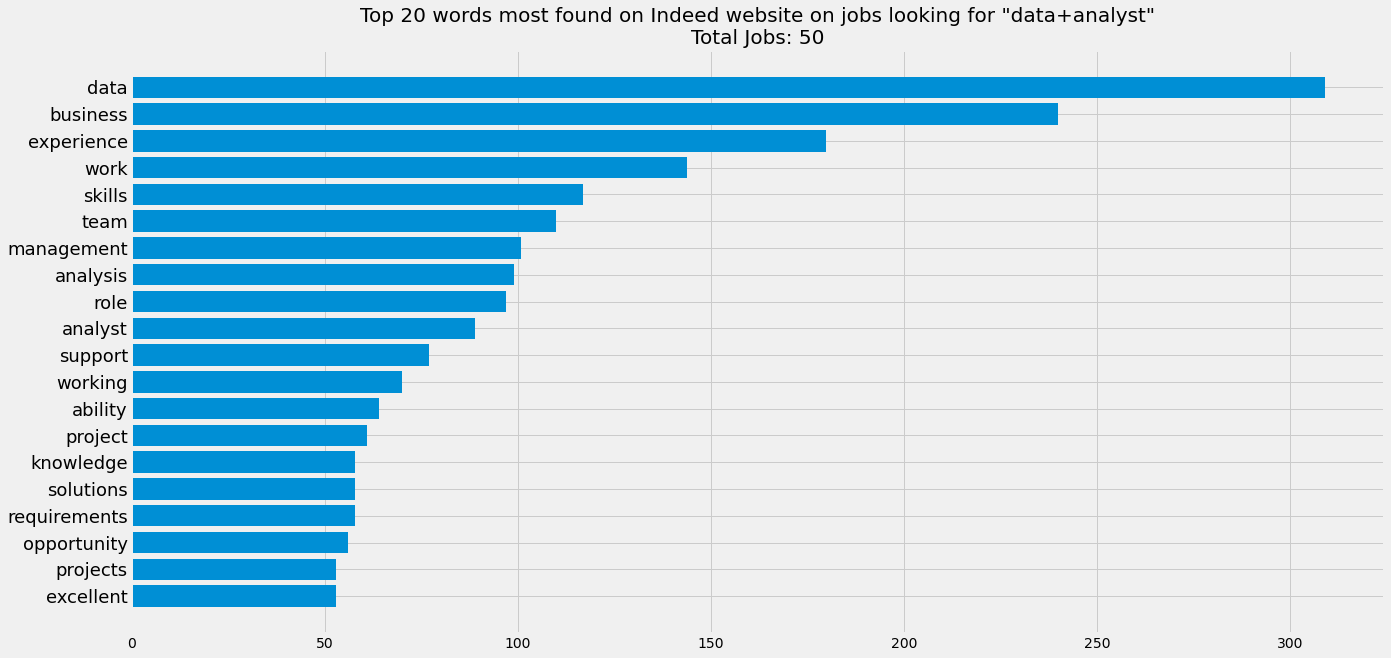

In [36]:
# plot the top20 words
df_top = df_word_count.head(20)

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.title(f'Top 20 words most found on Indeed website on jobs looking for "{word}"\nTotal Jobs: {total_comp}',fontsize=20)
plt.barh(df_top['word'],df_top['count'])
plt.yticks(fontsize=18)
plt.gca().invert_yaxis()
plt.show()

### Let´s check some skills that the companies are looking for

In [37]:
# https://www.indeed.com/career-advice/resumes-cover-letters/data-analyst-skills-resume
skills = ['python','database','sql','oracle','sybase','tableau', 'power','pentaho','excel', 'aws','git','scrum','agile','statistic','math','report','visualiz','azure','cloud','lifecycle','etl',
          'model','decision','collect','clean','present','communication','logic','detail','predictive','warehous','machine','mining']

list_skills = []
for s in skills:
    list_skills.append((s,'/'.join(df['company'][df['full description'].str.lower().str.contains(s)])))
    
df_skill = pd.DataFrame(list_skills, columns=['skill','companies'])

# insert a column with the total of companies looking for the skill
df_skill['total'] = df_skill['companies'].str.count('/')
df_skill.sort_values(by='total',ascending=False,inplace=True)
df_skill

,skill,companies,total
8,excel,Facebook/Pfizer/Citi/Amazon EU SARL/Darwin Hawkins/Amazon EU SARL/Amazon EU SARL/Kennedy and Partners Recruitment/Susquehanna International Group/GCS Recruitment Ireland/IBM/Salesforce/permanent tsb/fire.com/Ding/Morgan McKinley/permanent tsb/Brown Brothers Harriman/Reperio Human Capital/Matrix Recruitment Group/Tinder/Mars/Pfizer/Glofox/Reperio Human Capital/Mars/Amach Software/FRS Recruitment/Recruit.ie/Viatris/Salesforce/Viatris/Elevate Partners/Google/Aptiv/PokerStars/Mercury Engineering/PokerStars/Trūata/Accountancy Solutions,39
26,communication,Pfizer/Amazon EU SARL/Amazon Services EuropeSARL(LU)/Amazon EU SARL/Kennedy and Partners Recruitment/Susquehanna International Group/permanent tsb/Ding/Coinbase/Morgan McKinley/permanent tsb/Brown Brothers Harriman/Reperio Human Capital/Matrix Recruitment Group/Deloitte/Citi/Tinder/Dun & Bradstreet/Mars/Pfizer/Glofox/Amach Software/FRS Recruitment/Dun & Bradstreet/Recruit.ie/Viatris/Salesforce/Viatris/Elevate Partners/Google/Aptiv/Novartis,31
15,report,Facebook/Citi/Amazon EU SARL/Darwin Hawkins/Amazon Services EuropeSARL(LU)/Amazon EU SARL/Kennedy and Partners Recruitment/IBM/Salesforce/fire.com/Brown Brothers Harriman/Deloitte/Citi/Tinder/Dun & Bradstreet/Mars/Pfizer/Glofox/Reperio Human Capital/Mars/FRS Recruitment/Dun & Bradstreet/Recruit.ie/Viatris/Viatris/Aptiv/Novartis/Novartis/PokerStars/PokerStars/Trūata/Accountancy Solutions,31
25,present,Facebook/Pfizer/Citi/Amazon EU SARL/Kennedy and Partners Recruitment/GCS Recruitment Ireland/IBM/Salesforce/Tinder/Dun & Bradstreet/Pfizer/Reperio Human Capital/Mars/Amach Software/FRS Recruitment/Dun & Bradstreet/Recruit.ie/Viatris/Salesforce/Viatris/Elevate Partners/Google/Aptiv/Novartis/Novartis/Mercury Engineering/PokerStars,26
21,model,Pfizer/Amazon EU SARL/Amazon Services EuropeSARL(LU)/Amazon EU SARL/Kennedy and Partners Recruitment/IBM/Salesforce/permanent tsb/fire.com/Ding/permanent tsb/Deloitte/Pfizer/Glofox/Reperio Human Capital/Mars/Dun & Bradstreet/Elevate Partners/Novartis/Novartis/PokerStars/Trūata/Accountancy Solutions,22
2,sql,Amazon EU SARL/Amazon EU SARL/Amazon Services EuropeSARL(LU)/Amazon EU SARL/Susquehanna International Group/Salesforce/fire.com/Ding/Morgan McKinley/permanent tsb/Tinder/Dun & Bradstreet/Pfizer/Glofox/Reperio Human Capital/Dun & Bradstreet/Recruit.ie/Google/Novartis/Novartis/PokerStars/Trūata/Accountancy Solutions,22
6,power,Facebook/Pfizer/Citi/Darwin Hawkins/Susquehanna International Group/IBM/permanent tsb/permanent tsb/Deloitte/Tinder/Dun & Bradstreet/Pfizer/Glofox/Reperio Human Capital/Mars/Dun & Bradstreet/Viatris/Viatris/Aptiv/Novartis/Novartis/PokerStars/Trūata,22
13,statistic,Amazon EU SARL/Amazon Services EuropeSARL(LU)/Amazon EU SARL/Kennedy and Partners Recruitment/permanent tsb/fire.com/Ding/permanent tsb/Deloitte/Citi/Pfizer/Reperio Human Capital/Recruit.ie/Viatris/Viatris/Google/Aptiv/Novartis/Novartis/PokerStars,19
28,detail,Facebook/Amazon EU SARL/Darwin Hawkins/Amazon EU SARL/Amazon Services EuropeSARL(LU)/Amazon EU SARL/GCS Recruitment Ireland/Salesforce/Morgan McKinley/Brown Brothers Harriman/Deloitte/Mars/Amach Software/FRS Recruitment/Salesforce/Elevate Partners/PokerStars/PokerStars,17
22,decision,Pfizer/Amazon EU SARL/Susquehanna International Group/IBM/Salesforce/fire.com/permanent tsb/Citi/Dun & Bradstreet/Pfizer/Reperio Human Capital/FRS Recruitment/Dun & Bradstreet/Recruit.ie/Viatris/Viatris/Google/Aptiv,17


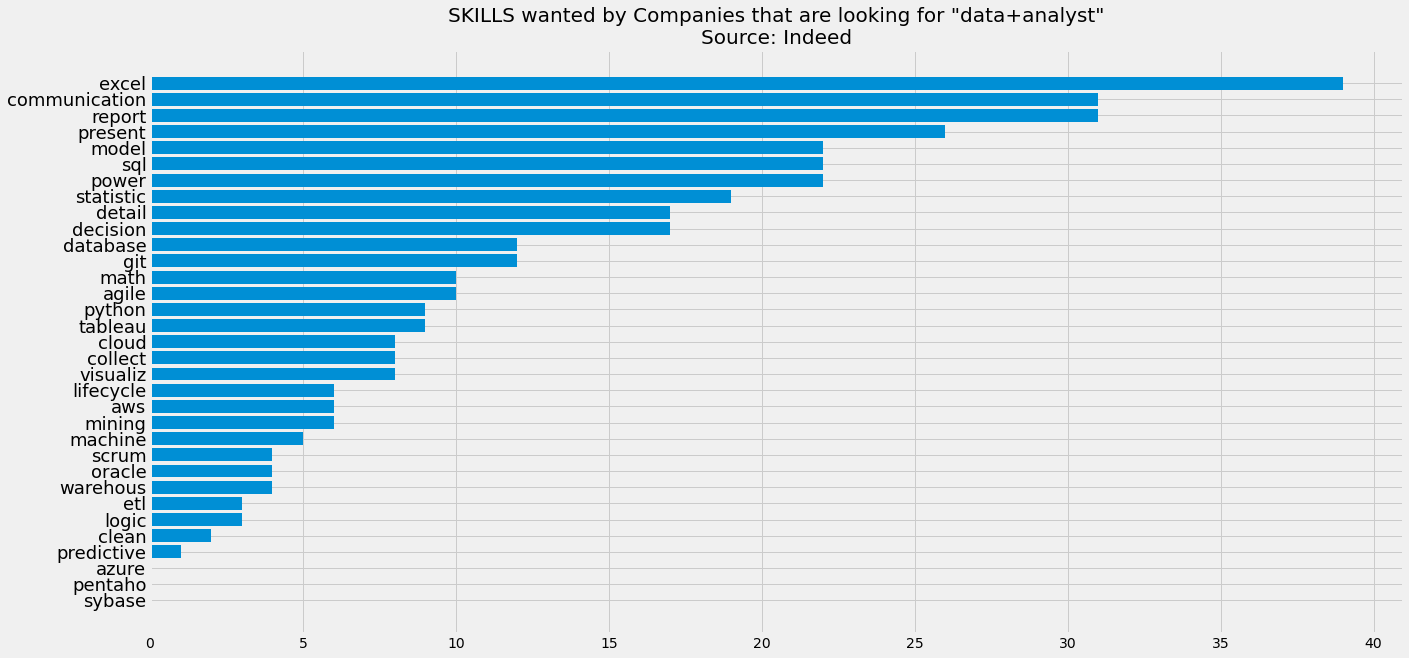

In [38]:
# plot the skills per company

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.title(f'SKILLS wanted by Companies that are looking for "{word}"\nSource: Indeed',fontsize=20)
plt.barh(df_skill['skill'],df_skill['total'])
plt.yticks(fontsize=18)
plt.gca().invert_yaxis()
plt.show()

### Conclusion:
Observing the plots above we can see that the companies looking for Data Analyst on Indeed website, 
Excel and SQL are the most wanted technical skill and
Data, business and experience are the most wanted soft skill